In [1]:
# load libraries
import os
import torch
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from torch import optim
from torch.utils.data import DataLoader

os.chdir("..")
from data.dataset import ConditionalDataset
from data.utils import to_one_hot, load_sz_score, load_dfnc, vector2matrix, compute_sub_per_state, compute_fnc_per_state, compute_dwell_state, compute_transition_matrix, find_unique_ind
from models.vae import VAE
from models.ivae import iVAE
from models.utils import EarlyStopper
from visualization.utils import plot_fnc

In [2]:
# set VAE parameters
method = 'vae'
seed = 8
n_layer = 7
hidden_dim = [512, 256, 128, 64, 32, 16, 8]
latent_dim = 2
batch_size = 512
learning_rate = 0.001
n_epoch = 1000
cuda = False
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
res_path = f'/data/users4/xli/interpolation/results/dfnc_sz/{method}/test'
os.mkdir(res_path) if not os.path.exists(res_path) else None
ckpt_file = os.path.join(res_path, f'{method}_layer{n_layer}_dim{hidden_dim}_bs{batch_size}_lr{learning_rate}_seed{seed}.pt')

# load subject measures and dFNC data
data_path = '/data/users2/zfu/Matlab/GSU/Neuromark/Results'
fbirn_sub_path = os.path.join(data_path, 'Subject_selection', 'FBIRN', 'sub_info_FBIRN.mat')
fbirn_sub_data, invalid_sub_ind = load_sz_score(fbirn_sub_path)
fbirn_dfnc_path = os.path.join(data_path, 'DFNC', 'FBIRN', 'FBIRN_dfnc_sub_*_sess_001_results.mat')
fbirn_dfnc_data = load_dfnc(fbirn_dfnc_path, invalid_sub_ind)

# count the number of patients and controls
n_sub = fbirn_sub_data.shape[0]
ind_pt = np.where(fbirn_sub_data[:, 0]==1)[0][:n_sub//2]
ind_hc = np.where(fbirn_sub_data[:, 0]==2)[0][:(n_sub-ind_pt.shape[0])]
print(f"N patient = {ind_pt.shape[0]}; N control = {ind_hc.shape[0]}")

# split the data into training and testing sets
n_test = 41
n_train = n_sub - n_test
ind_pt_test = ind_pt[:n_test//2]
ind_pt_train = ind_pt[n_test//2:]
ind_hc_test = ind_hc[:n_test-n_test//2]
ind_hc_train = ind_hc[n_test-n_test//2:]
n_pt_train = len(ind_pt_train)
n_hc_train = len(ind_hc_train)
n_pt_test = len(ind_pt_test)
n_hc_test = len(ind_hc_test)
print(f"N patient test = {n_pt_test}; N control test = {n_hc_test}; N patient train = {n_pt_train}; N control train = {n_hc_train}")

dfnc_data_test = np.concatenate((fbirn_dfnc_data[ind_pt_test, :, :], fbirn_dfnc_data[ind_hc_test, :, :]), axis=0)
sub_data_test = np.concatenate((fbirn_sub_data[ind_pt_test, :], fbirn_sub_data[ind_hc_test, :]), axis=0)
dfnc_data_train = np.concatenate((fbirn_dfnc_data[ind_pt_train, :], fbirn_dfnc_data[ind_hc_train, :]), axis=0)
sub_data_train = np.concatenate((fbirn_sub_data[ind_pt_train, :], fbirn_sub_data[ind_hc_train, :]), axis=0)

n_window = dfnc_data_test.shape[1]
n_feature = dfnc_data_test.shape[2]  
print(f"n_window = {n_window}; n_feature = {n_feature}")

dfnc_data_test_2d = dfnc_data_test.reshape((n_test*n_window, n_feature))
dfnc_data_train_2d = dfnc_data_train.reshape((n_train*n_window, n_feature))

y_test = to_one_hot(np.array([1]*n_pt_test*n_window+[2]*n_hc_test*n_window))[0][:,1:]
y_train = to_one_hot(np.array([1]*n_pt_train*n_window+[2]*n_hc_train*n_window))[0][:,1:]

data_dim = dfnc_data_train_2d.shape[1]
aux_dim = y_train.shape[1]

N patient = 125; N control = 141
N patient test = 20; N control test = 21; N patient train = 105; N control train = 120
n_window = 137; n_feature = 1378


In [3]:
kmeans_list = []
loss_l1_list = []
loss_l2_list = []
cluster_center_list = []
label_list = []
all_state_list = []

for nc in range(2,10):
    kmeans = KMeans(n_clusters=nc, random_state=0).fit(dfnc_data_train_2d)
    kmeans_list.append(kmeans)
    cluster_center = kmeans.cluster_centers_
    cluster_center_list.append(cluster_center)
    label = kmeans.labels_
    label_list.append(label)

    # K-means states
    state_list = []
    for i in range(nc):
        state = vector2matrix(cluster_center[i])
        state_list.append(state)
    all_state_list.append(state_list)

    loss_l1, loss_l2 = 0, 0
    for i, l in enumerate(label):
        loss_l1 += np.sum(np.abs(cluster_center[l]-dfnc_data_train_2d[i,:])) # L1 norm
        loss_l2 += np.sum((cluster_center[l]-dfnc_data_train_2d[i,:])**2) # L2 norm
    loss_l1 /= n_train*n_window
    loss_l2 /= n_train*n_window
    loss_l1_list.append(loss_l1)
    loss_l2_list.append(loss_l2)

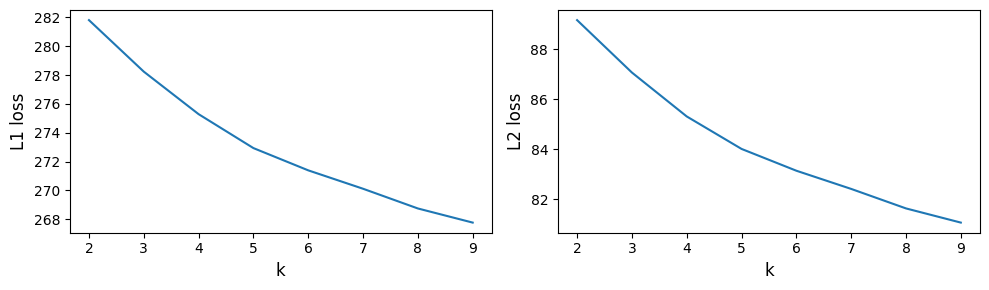

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(10,3))
axes[0].plot(range(2,10), loss_l1_list)
axes[0].set_xlabel("k", fontsize=12)
axes[0].set_ylabel("L1 loss", fontsize=12)
axes[1].plot(range(2,10), loss_l2_list)
axes[1].set_xlabel("k", fontsize=12)
axes[1].set_ylabel("L2 loss", fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(res_path, 'dfnc_kmeans_loss.png'), dpi=500)

In [5]:
n_state = 5 # state 5

# np.save(os.path.join(res_path, 'loss_l1_list.npy'), loss_l1_list)
# np.save(os.path.join(res_path, 'loss_l2_list.npy'), loss_l2_list)
# np.save(os.path.join(res_path, f'label_state{n_state}.npy'), label_list[n_state-2])
# np.save(os.path.join(res_path, f'cluster_center_state{n_state}.npy'), cluster_center_list[n_state-2])
# np.save(os.path.join(res_path, f'all_state_state{n_state}.npy'), all_state_list[n_state-2])
# kmeans_state = all_state_list[n_state-2]
# kmeans_label = label_list[n_state-2]
# kmeans_cluster_center = cluster_center_list[n_state-2]

kmeans_state = np.load(os.path.join(res_path, f'all_state_state{n_state}.npy'), allow_pickle=True)
kmeans_label = np.load(os.path.join(res_path, f'label_state{n_state}.npy'))
kmeans_cluster_center = np.load(os.path.join(res_path, f'cluster_center_state{n_state}.npy'))

label_pt = kmeans_label[:n_pt_train*n_window]
label_hc = kmeans_label[n_pt_train*n_window:]
dfnc_data_train_2d_pt = dfnc_data_train_2d[:n_pt_train*n_window,:]
dfnc_data_train_2d_hc = dfnc_data_train_2d[n_pt_train*n_window:,:]

num_sub_per_state, ratio_sub_per_state = compute_sub_per_state(kmeans_label, n_pt_train)
num_fnc_per_state, ratio_fnc_per_state = compute_fnc_per_state(kmeans_label, n_pt_train)
sorted_state_ind = np.argsort(ratio_fnc_per_state[1,:])
ratio_fnc_per_state_sorted = ratio_fnc_per_state[:, sorted_state_ind]

print(num_sub_per_state)
print(ratio_sub_per_state)
print(num_fnc_per_state)
print(ratio_fnc_per_state)
print(sorted_state_ind)

[[ 96.  49.  64.  26.  40.]
 [105.  42.  89.  70.  92.]]
[[0.47761194 0.53846154 0.41830065 0.27083333 0.3030303 ]
 [0.52238806 0.46153846 0.58169935 0.72916667 0.6969697 ]]
[[7026. 2869. 2146.  855. 1489.]
 [5468.  963. 2640. 2993. 4376.]]
[[0.56234993 0.7486952  0.44839114 0.22219335 0.25387894]
 [0.43765007 0.2513048  0.55160886 0.77780665 0.74612106]]
[1 0 2 4 3]


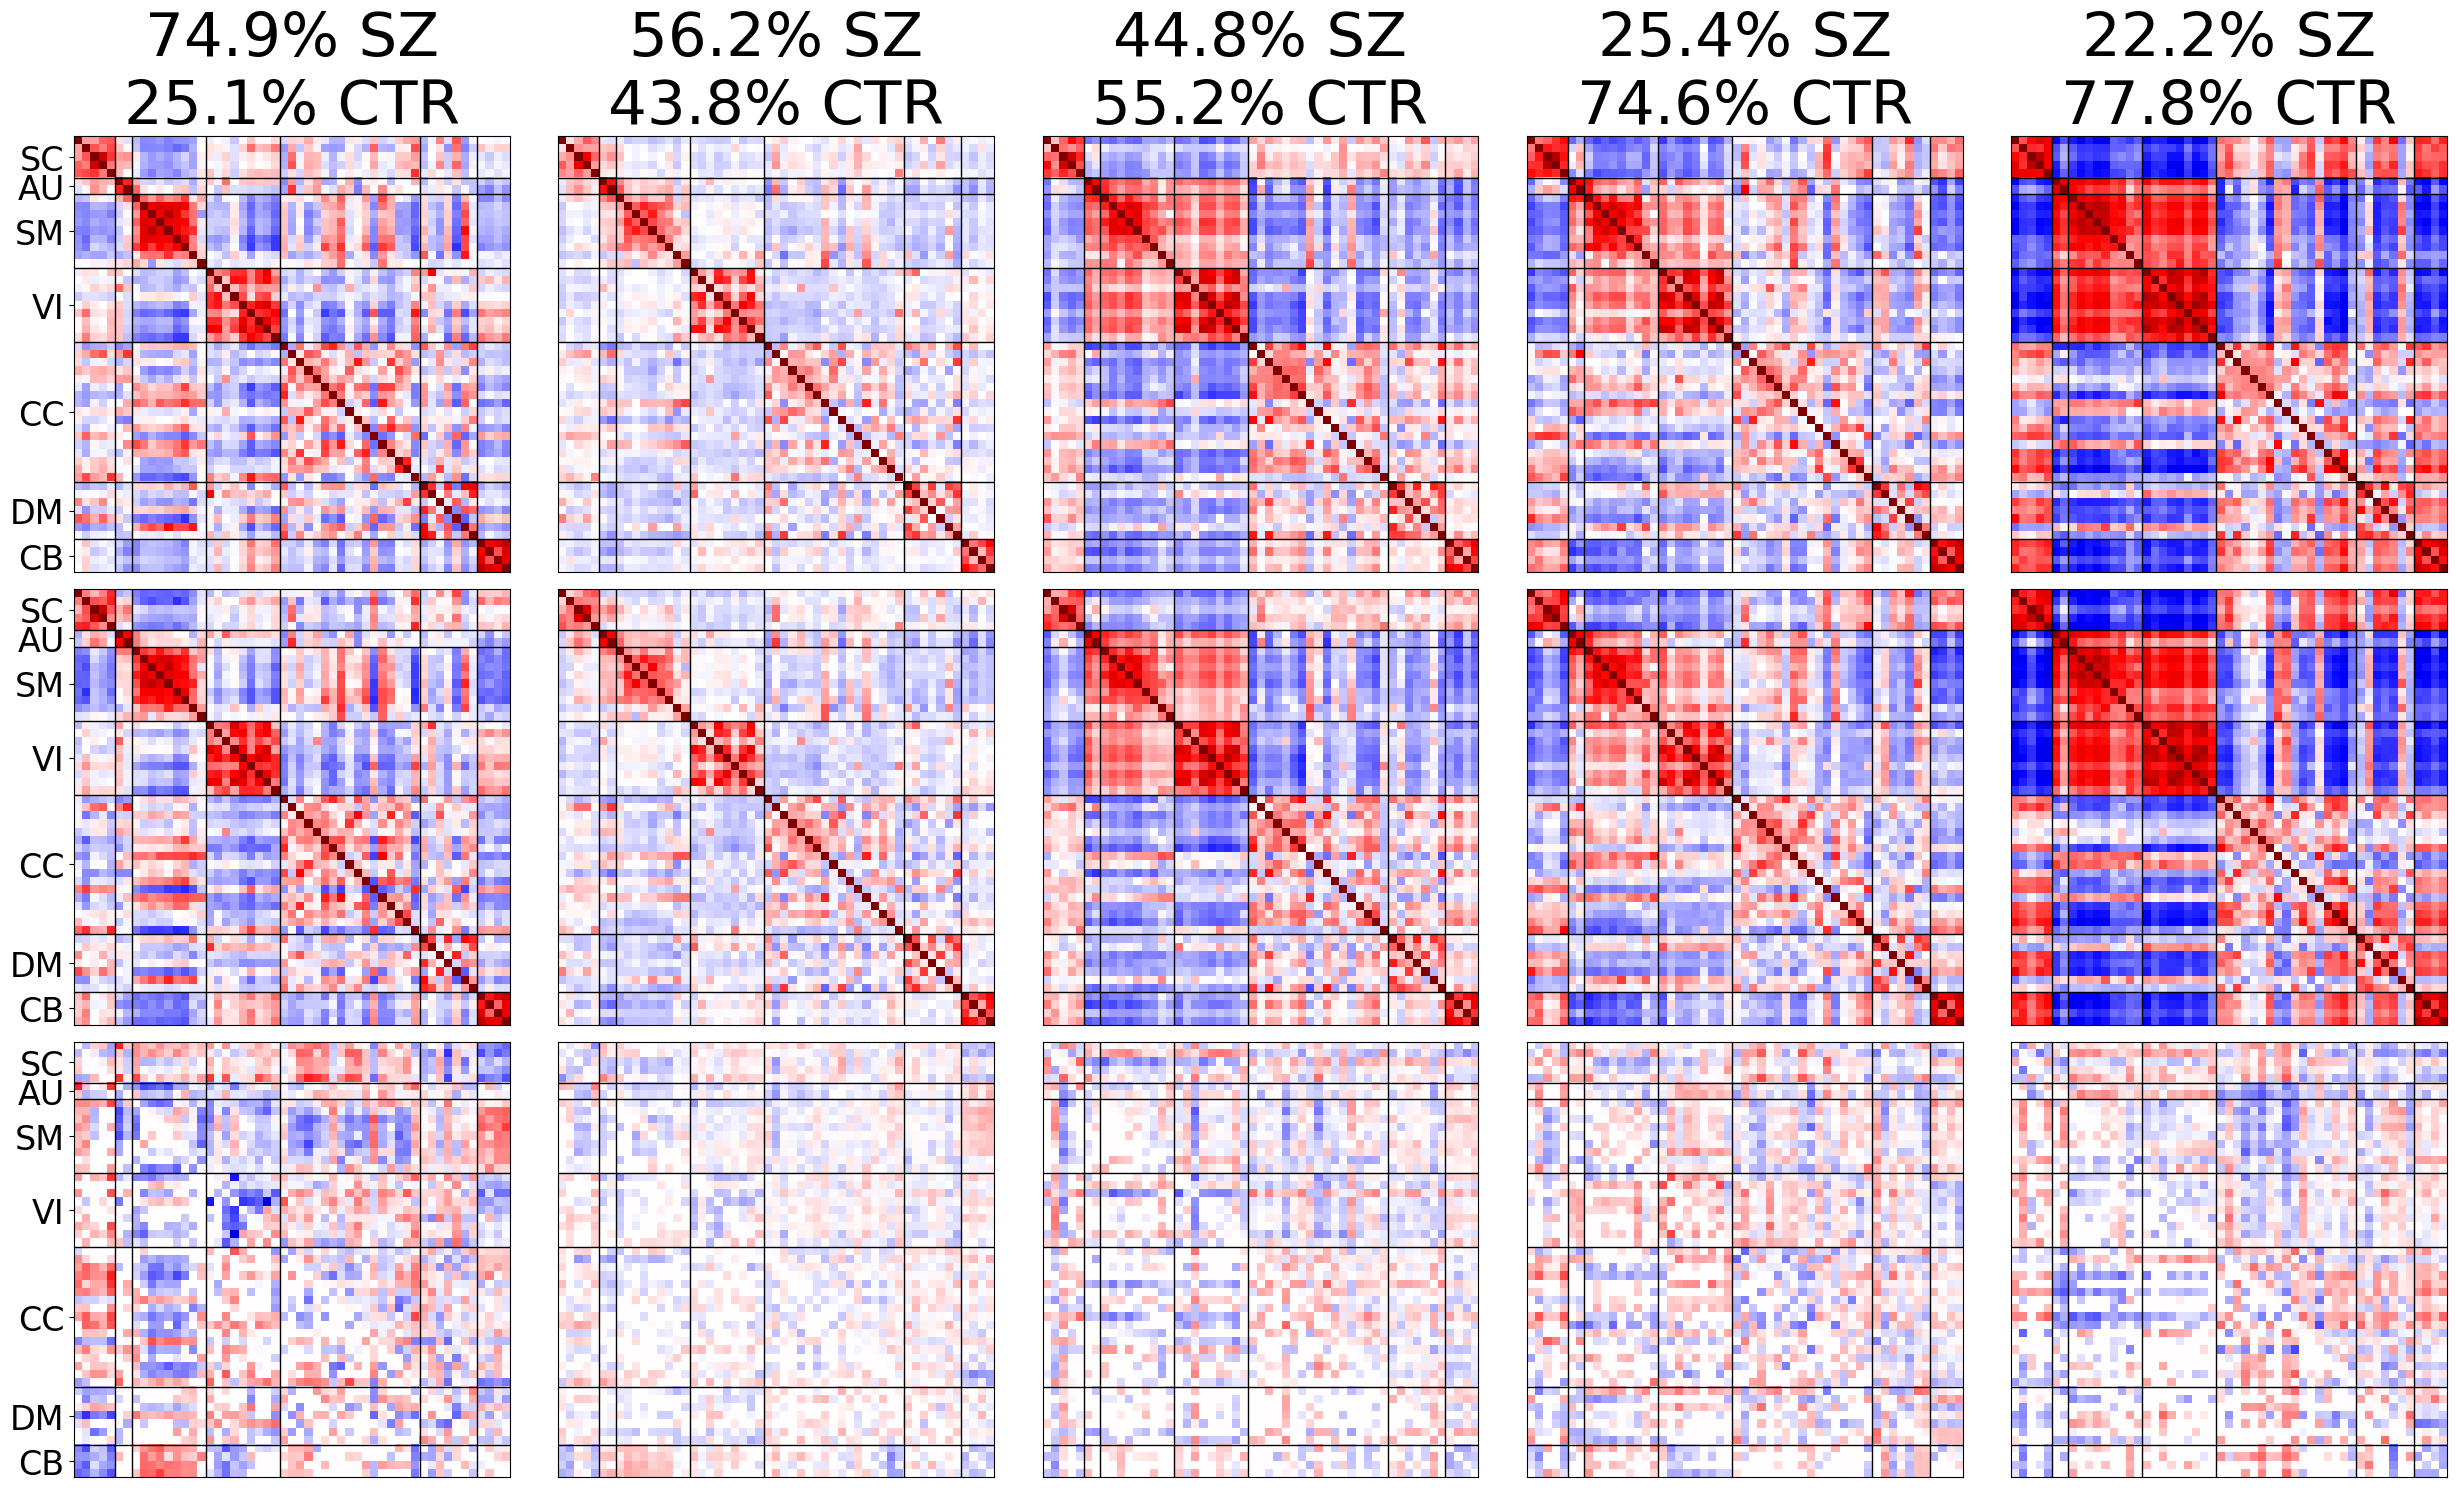

In [6]:
dfnc_state = np.zeros((3, 5, 53, 53))

fig, axes = plt.subplots(nrows=3, ncols=n_state, figsize=(5*n_state, 5*3))

for i, j in enumerate(np.arange(n_state)[sorted_state_ind]):
  state_pt = dfnc_data_train_2d_pt[np.where(label_pt == j)[0],:]
  state_hc = dfnc_data_train_2d_hc[np.where(label_hc == j)[0],:]
  stat, pvalue = stats.ttest_ind(a=state_pt, b=state_hc, equal_var=True)
  pvalue_map = vector2matrix(pvalue)
  pvalue_mask = pvalue_map <= (0.05/len(pvalue))
  upper_triangle_mask = np.triu(np.ones_like(pvalue_mask)).astype(bool)
  pvalue_mask[upper_triangle_mask] = 1
  cluster_median_1d_pt = np.median(state_pt, axis=0)
  cluster_median_1d_hc = np.median(state_hc, axis=0)
  dfnc_state[0,i] = vector2matrix(cluster_median_1d_pt)
  dfnc_state[1,i] = vector2matrix(cluster_median_1d_hc)
  dfnc_state[2,i] = dfnc_state[0,i] - dfnc_state[1,i]
  if i == 0:
    show_xticks = True
  else:
    show_xticks = False
  plot_fnc(dfnc_state[0,i], axes[0,i], f"{round(ratio_fnc_per_state_sorted[0,i]*100,1)}% SZ\n{round(ratio_fnc_per_state_sorted[1,i]*100,1)}% CTR", show_xticks=show_xticks)
  plot_fnc(dfnc_state[1,i], axes[1,i], show_xticks=show_xticks)
  plot_fnc(dfnc_state[2,i] * pvalue_mask * 2, axes[2,i], show_xticks=show_xticks)

plt.tight_layout()
plt.savefig(os.path.join(res_path, f'dfnc_kmeans_{n_state}states_pt_hc_pt-hc_sorted.png'), dpi=500)

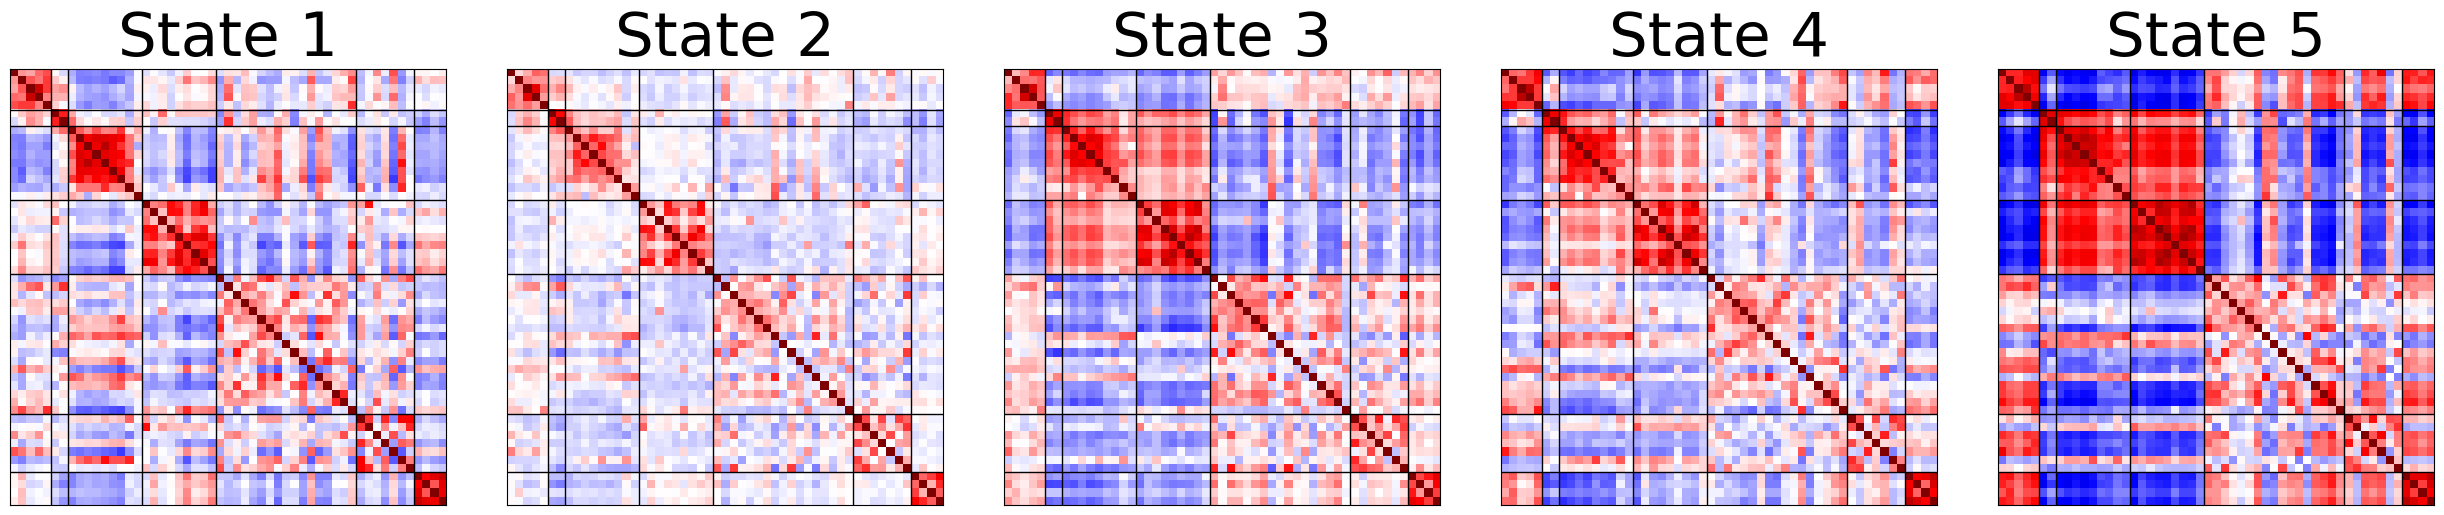

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(5*n_state, 5))

for i, j in enumerate(np.arange(n_state)[sorted_state_ind]):
  state = dfnc_data_train_2d[np.where(kmeans_label == j)[0], :]
  state_median_1d = np.median(state, axis=0)
  state_median_2d = vector2matrix(state_median_1d)
  plot_fnc(state_median_2d, axes[i], f"State {i+1}")

plt.tight_layout()
plt.savefig(os.path.join(res_path, f'dfnc_kmeans_{n_state}states_pt_sorted.png'), bbox_inches='tight', dpi=500)

In [8]:
dwell_time = num_fnc_per_state / num_sub_per_state
dwell_time_sorted = dwell_time[:, sorted_state_ind]

kmeans_label_2d = kmeans_label.reshape((n_train, n_window))
dwell_state_mean_pt, dwell_state_ste_pt, dwell_state_mean_hc, dwell_state_ste_hc, dwell_state_pvalue = compute_dwell_state(kmeans_label_2d, sorted_state_ind, n_pt_train, n_hc_train)
transition_matrix_pt, transition_matrix_hc, transition_matrix, transition_matrix_pvalue = compute_transition_matrix(kmeans_label_2d, sorted_state_ind, n_pt_train)

np.save(os.path.join(res_path, 'dwell_time.npy'), dwell_time_sorted)
np.save(os.path.join(res_path, 'dwell_state_pvalue.npy'), dwell_state_pvalue)
np.save(os.path.join(res_path, 'dwell_state_mean_pt.npy'), dwell_state_mean_pt)
np.save(os.path.join(res_path, 'dwell_state_ste_pt.npy'), dwell_state_ste_pt)
np.save(os.path.join(res_path, 'dwell_state_mean_hc.npy'), dwell_state_mean_hc)
np.save(os.path.join(res_path, 'dwell_state_ste_hc.npy'), dwell_state_ste_hc)
np.save(os.path.join(res_path, 'transition_matrix_pt.npy'), transition_matrix_pt)
np.save(os.path.join(res_path, 'transition_matrix_hc.npy'), transition_matrix_hc)
np.save(os.path.join(res_path, 'transition_matrix.npy'), transition_matrix)
np.save(os.path.join(res_path, 'transition_matrix_pvalue.npy'), transition_matrix_pvalue)

In [9]:
kmeans = kmeans_list[n_state-2]
kmeans_label_test = kmeans.predict(dfnc_data_test_2d)
label_pt_test = kmeans_label_test[:n_pt_test*n_window]
label_hc_test = kmeans_label_test[n_pt_test*n_window:]
dfnc_data_test_2d_pt = dfnc_data_test_2d[:n_pt_test*n_window,:]
dfnc_data_test_2d_hc = dfnc_data_test_2d[n_pt_test*n_window:,:]

num_sub_per_state_test, ratio_sub_per_state_test = compute_sub_per_state(kmeans_label_test, n_pt_test)
num_fnc_per_state_test, ratio_fnc_per_state_test = compute_fnc_per_state(kmeans_label_test, n_pt_test)
sorted_state_ind_test = np.argsort(ratio_fnc_per_state_test[1,:])
ratio_fnc_per_state_sorted_test = ratio_fnc_per_state_test[:, sorted_state_ind_test]

print(num_sub_per_state_test)
print(ratio_sub_per_state_test)
print(num_fnc_per_state_test)
print(ratio_fnc_per_state_test)
print(sorted_state_ind_test)

[[18.  6. 13.  2.  6.]
 [15.  4. 18. 13. 12.]]
[[0.54545455 0.6        0.41935484 0.13333333 0.33333333]
 [0.45454545 0.4        0.58064516 0.86666667 0.66666667]]
[[1697.  294.  443.  108.  198.]
 [1010.   43.  608.  613.  603.]]
[[0.62689324 0.87240356 0.42150333 0.14979196 0.24719101]
 [0.37310676 0.12759644 0.57849667 0.85020804 0.75280899]]
[1 0 2 4 3]


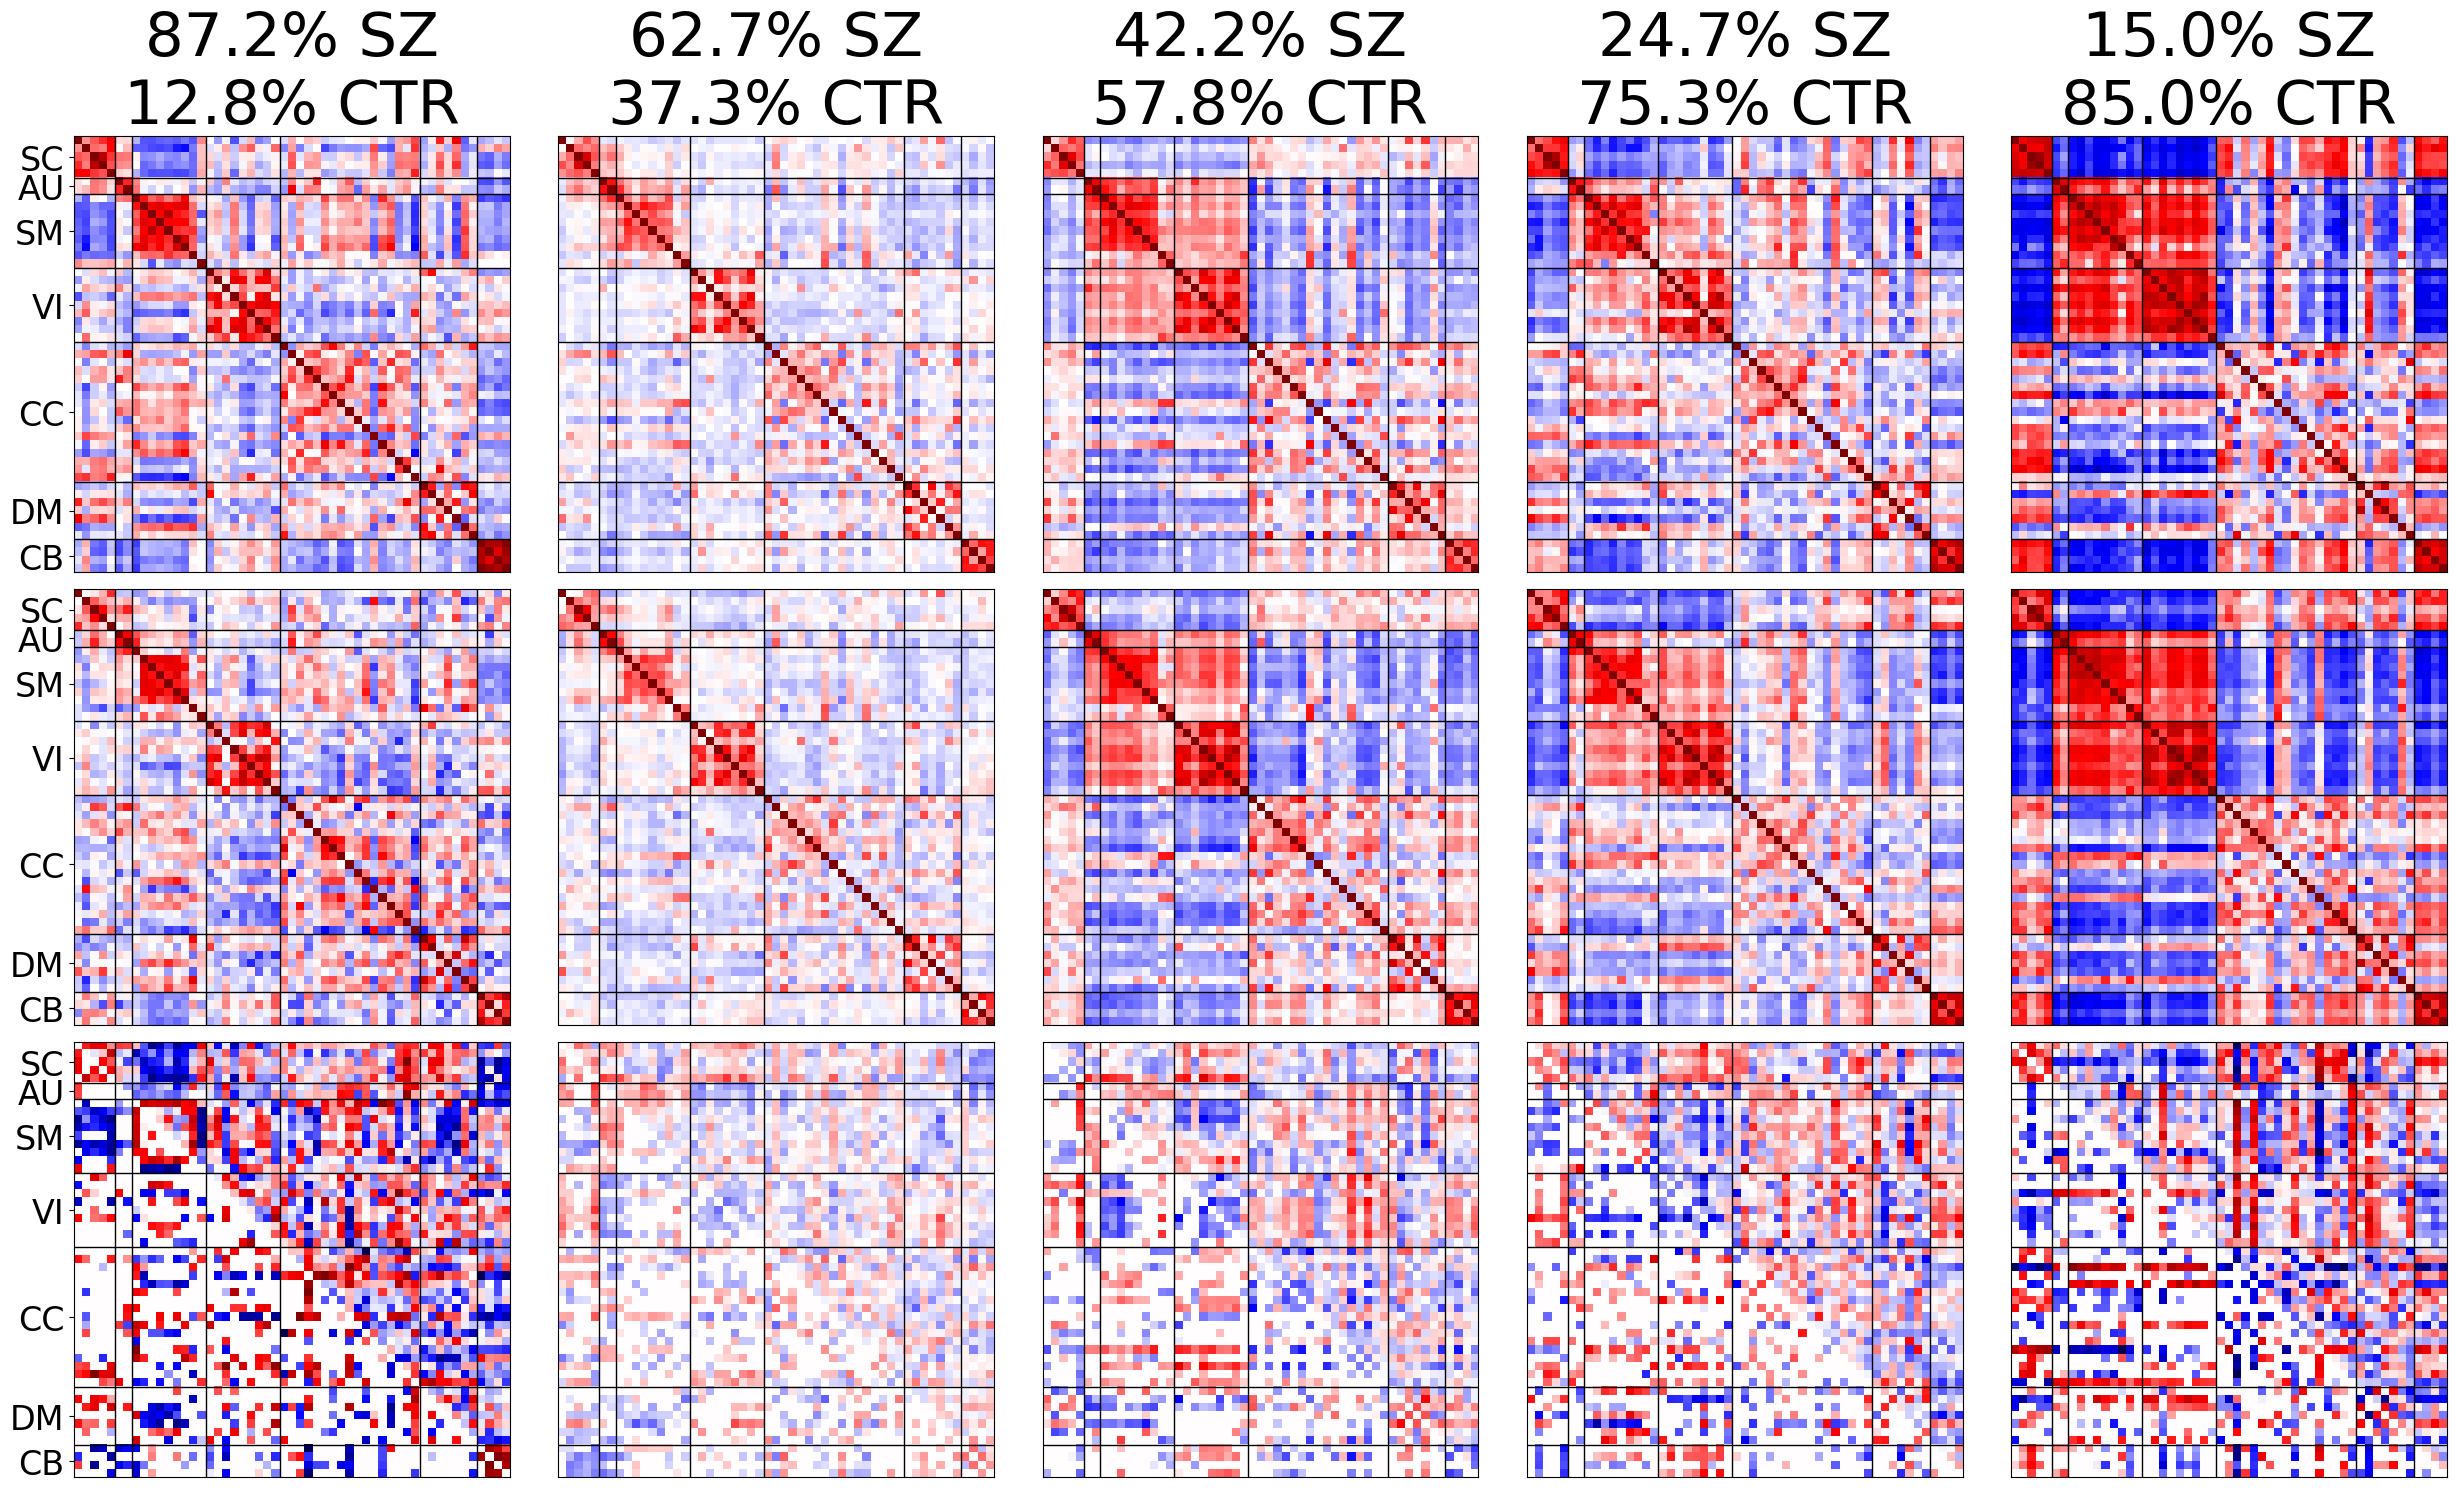

In [10]:
dfnc_state_test = np.zeros((3, 5, 53, 53))

fig, axes = plt.subplots(nrows=3, ncols=n_state, figsize=(5*n_state, 5*3))

for i, j in enumerate(np.arange(n_state)[sorted_state_ind_test]):
  state_pt = dfnc_data_test_2d_pt[np.where(label_pt_test == j)[0],:]
  state_hc = dfnc_data_test_2d_hc[np.where(label_hc_test == j)[0],:]
  stat, pvalue = stats.ttest_ind(a=state_pt, b=state_hc, equal_var=True)
  pvalue_map = vector2matrix(pvalue)
  pvalue_mask = pvalue_map <= (0.05/len(pvalue))
  upper_triangle_mask = np.triu(np.ones_like(pvalue_mask)).astype(bool)
  pvalue_mask[upper_triangle_mask] = 1
  cluster_median_1d_pt = np.median(state_pt, axis=0)
  cluster_median_1d_hc = np.median(state_hc, axis=0)
  dfnc_state_test[0,i] = vector2matrix(cluster_median_1d_pt)
  dfnc_state_test[1,i] = vector2matrix(cluster_median_1d_hc)
  dfnc_state_test[2,i] = dfnc_state_test[0,i] - dfnc_state_test[1,i]
  if i == 0:
    show_xticks = True
  else:
    show_xticks = False
  plot_fnc(dfnc_state_test[0,i], axes[0,i], f"{round(ratio_fnc_per_state_sorted_test[0,i]*100,1)}% SZ\n{round(ratio_fnc_per_state_sorted_test[1,i]*100,1)}% CTR", show_xticks=show_xticks)
  plot_fnc(dfnc_state_test[1,i], axes[1,i], show_xticks=show_xticks)
  plot_fnc(dfnc_state_test[2,i] * pvalue_mask * 2, axes[2,i], show_xticks=show_xticks)

plt.tight_layout()
plt.savefig(os.path.join(res_path, f'dfnc_kmeans_{n_state}states_pt_hc_pt-hc_sorted_test.png'), dpi=500)

In [11]:
dwell_time_test = num_fnc_per_state_test / num_sub_per_state_test
dwell_time_sorted_test = dwell_time_test[:, sorted_state_ind_test]
kmeans_label_2d_test = kmeans_label_test.reshape((n_test, n_window))

dwell_state_mean_pt_test, dwell_state_ste_pt_test, dwell_state_mean_hc_test, dwell_state_ste_hc_test, dwell_state_pvalue_test = compute_dwell_state(kmeans_label_2d_test, sorted_state_ind_test, n_pt_test, n_hc_test)
transition_matrix_pt_test, transition_matrix_hc_test, transition_matrix_test, transition_matrix_pvalue_test = compute_transition_matrix(kmeans_label_2d_test, sorted_state_ind_test, n_pt_test)

np.save(os.path.join(res_path, 'dwell_time_test.npy'), dwell_time_sorted_test)
np.save(os.path.join(res_path, 'dwell_state_pvalue_test.npy'), dwell_state_pvalue_test)
np.save(os.path.join(res_path, 'dwell_state_mean_pt_test.npy'), dwell_state_mean_pt_test)
np.save(os.path.join(res_path, 'dwell_state_ste_pt_test.npy'), dwell_state_ste_pt_test)
np.save(os.path.join(res_path, 'dwell_state_mean_hc_test.npy'), dwell_state_mean_hc_test)
np.save(os.path.join(res_path, 'dwell_state_ste_hc_test.npy'), dwell_state_ste_hc_test)
np.save(os.path.join(res_path, 'transition_matrix_pt_test.npy'), transition_matrix_pt_test)
np.save(os.path.join(res_path, 'transition_matrix_hc_test.npy'), transition_matrix_hc_test)
np.save(os.path.join(res_path, 'transition_matrix_test.npy'), transition_matrix_test)
np.save(os.path.join(res_path, 'transition_matrix_pvalue_test.npy'), transition_matrix_pvalue_test)

In [12]:
loader_params = {'num_workers': 1, 'pin_memory': True} if cuda else {}

ds_train = ConditionalDataset(dfnc_data_train_2d.astype(np.float32), y_train.astype(np.float32), device)
data_loader_train = DataLoader(ds_train, shuffle=False, batch_size=batch_size, **loader_params)

ds_test = ConditionalDataset(dfnc_data_test_2d.astype(np.float32), y_test.astype(np.float32), device)
data_loader_test = DataLoader(ds_test, shuffle=False, batch_size=batch_size, **loader_params)

In [13]:
if method == 'vae':
    model = VAE(input_dim=data_dim, 
                latent_dim=latent_dim, 
                hidden_dims=hidden_dim, 
                seed=seed)
    print(model)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
    early_stopper = EarlyStopper(patience=20, threshold=1e-2, min_delta=1e-3)

    # train model
    model.train()
    for it in range(n_epoch):
        loss_train = 0
        for _, (x, _) in enumerate(data_loader_train):
            x = x.view(x.size(0), -1).to(device)
            optimizer.zero_grad()
            x_rec, mean, logvar = model(x)
            loss = model.loss(x_rec, x, mean, logvar)
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        loss_train /= len(data_loader_train)
        scheduler.step(loss_train)
        print(f'Epoch: {it}; Loss: {loss_train:.5f}')
        if early_stopper.early_stop(loss_train):
            print(f'Early stopping triggered!')
            break

    # save model checkpoint after training
    torch.save(model.state_dict(), ckpt_file)
    
    x_train, u_train = ds_train.x, ds_train.y
    x_test, u_test = ds_test.x, ds_test.y
    _, z_train, _ = model(x_train)
    _, z_test, _ = model(x_test)
    z_train = z_train.detach().cpu().numpy()
    z_test = z_test.detach().cpu().numpy()

elif method == 'ivae':
    model = iVAE(data_dim=data_dim,
                latent_dim=latent_dim,
                aux_dim=aux_dim,
                hidden_dim=hidden_dim,
                n_layer=n_layer,
                activation='xtanh',
                device=device,
                seed=seed)
    print(model)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
    early_stopper = EarlyStopper(patience=20, threshold=1e-2, min_delta=1e-3)

    # train model
    model.train()

    for it in range(n_epoch):
        loss_train = 0
        for _, (x, u) in enumerate(data_loader_train):
            optimizer.zero_grad()
            x, u = x.to(device), u.to(device)
            loss, z_est = model.loss(x, u)
            loss.mul(-1).backward()
            optimizer.step()
            loss_train += -loss.item()
        loss_train /= len(data_loader_train)
        scheduler.step(loss_train)
        print(f'Epoch: {it}; Loss: {loss_train:.3f}')
        if early_stopper.early_stop(loss_train):
            print(f'Early stopping triggered!')
            break

    # save model checkpoint after training
    torch.save(model.state_dict(), ckpt_file)

    x_train, u_train = ds_train.x, ds_train.y
    x_test, u_test = ds_test.x, ds_test.y
    _, _, z_train, _ = model(x_train, u_train)
    _, _, z_test, _ = model(x_test, u_test)
    z_train = z_train.detach().cpu().numpy()
    z_test = z_test.detach().cpu().numpy()

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=1378, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.5)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.5)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.5)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): LeakyReLU(negative_slope=0.5)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): LeakyReLU(negative_slope=0.5)
    (10): Linear(in_features=32, out_features=16, bias=True)
    (11): LeakyReLU(negative_slope=0.5)
    (12): Linear(in_features=16, out_features=8, bias=True)
    (13): LeakyReLU(negative_slope=0.5)
  )
  (fc_mean): Linear(in_features=8, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=8, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): LeakyReLU(negative_slope=0.5)
    (2): Linea

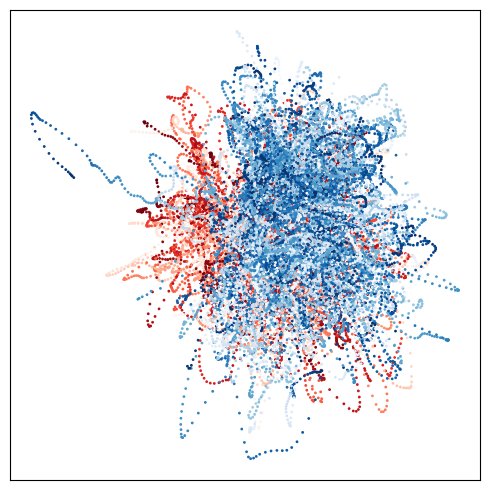

In [14]:
centroid_ms = 120
cols = plt.cm.Reds(np.linspace(0,1,n_window))
for i in range(n_pt_train-1):
  cols = np.concatenate([cols, plt.cm.Reds(np.linspace(0,1,n_window))])
for i in range(n_hc_train):
  cols = np.concatenate([cols, plt.cm.Blues(np.linspace(0,1,n_window))])
plt.figure(figsize=(5, 5))
plt.xticks([], [])
plt.yticks([], [])
plt.scatter(z_train[:, 0], z_train[:, 1], marker='o', c=cols, s=1)
plt.tight_layout()
plt.savefig(os.path.join(res_path, 'vae_latent_space_train.png'), dpi=500)

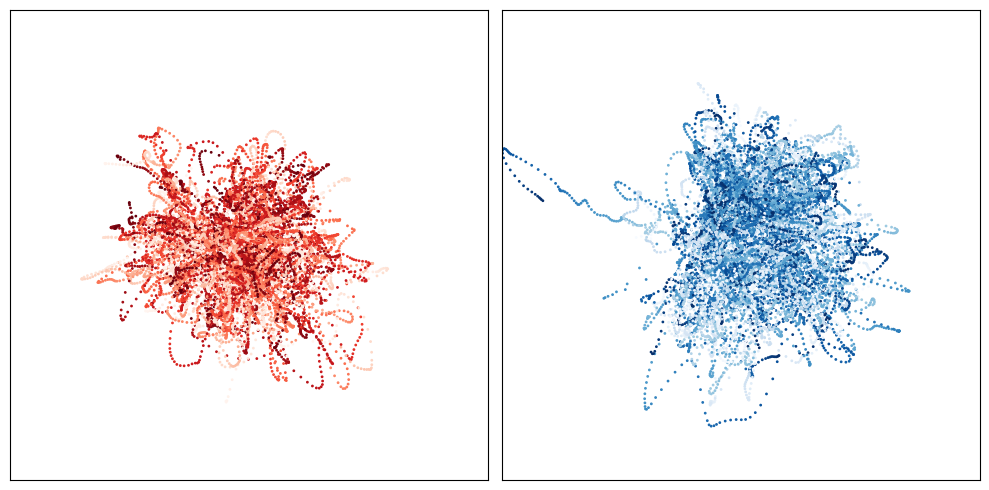

In [15]:
lim = np.max(np.abs(z_train))

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.xticks([], [])
plt.yticks([], [])
plt.scatter(z_train[:n_pt_train*n_window, 0], z_train[:n_pt_train*n_window, 1], marker='o', c=cols[:n_pt_train*n_window], s=1)
plt.xlim([-lim, lim])
plt.ylim([-lim, lim])

plt.subplot(1,2,2)
plt.xticks([], [])
plt.yticks([], [])
plt.scatter(z_train[n_pt_train*n_window:, 0], z_train[n_pt_train*n_window:, 1], marker='o', c=cols[n_pt_train*n_window:], s=1)
plt.xlim([-lim, lim])
plt.ylim([-lim, lim])

plt.tight_layout()
plt.savefig(os.path.join(res_path, 'vae_latent_space_train_pt_hc.png'), dpi=500)

In [16]:
vae_dfnc_data_train = np.zeros(dfnc_data_train_2d.shape)
for i in range(dfnc_data_train_2d.shape[0]):
  vae_z = torch.Tensor([[z_train[i,0], z_train[i,1]]])
  vae_dfnc_data_train[i,:] = np.squeeze(model.decode(vae_z).detach().numpy())
np.save(os.path.join(res_path, 'z_train.npy'), z_train)
np.save(os.path.join(res_path, 'z_test.npy'), z_test)
np.save(os.path.join(res_path, 'vae_dfnc_data_train.npy'), vae_dfnc_data_train)

# z_train = np.load(os.path.join(res_path, 'z_train.npy'))
# z_test = np.load(os.path.join(res_path, 'z_test.npy'))
# vae_dfnc_data_train = np.load(os.path.join(res_path, 'vae_dfnc_data_train.npy'))

In [17]:
model = VAE(input_dim=data_dim, 
            latent_dim=latent_dim, 
            hidden_dims=hidden_dim, 
            seed=seed)
ckpt_file = os.path.join(res_path, os.path.join(res_path, f'vae_layer{n_layer}_dim{hidden_dim}_bs512_lr0.001_seed{seed}.pt'))
checkpoint = torch.load(ckpt_file, map_location=torch.device('cpu'), weights_only=False)
model.load_state_dict(checkpoint)
model.eval()

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=1378, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.5)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.5)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.5)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): LeakyReLU(negative_slope=0.5)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): LeakyReLU(negative_slope=0.5)
    (10): Linear(in_features=32, out_features=16, bias=True)
    (11): LeakyReLU(negative_slope=0.5)
    (12): Linear(in_features=16, out_features=8, bias=True)
    (13): LeakyReLU(negative_slope=0.5)
  )
  (fc_mean): Linear(in_features=8, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=8, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): LeakyReLU(negative_slope=0.5)
    (2): Linea

In [18]:
vae_kmeans_list = []
vae_loss_l1_list = []
vae_loss_l2_list = []
vae_cluster_center_list = []
vae_label_list = []
vae_all_state_list = []

for nc in range(2,10):
  vae_kmeans = KMeans(n_clusters=nc, random_state=0).fit(z_train)
  vae_kmeans_list.append(vae_kmeans)
  vae_cluster_center = vae_kmeans.cluster_centers_
  vae_cluster_center_list.append(vae_cluster_center)
  vae_label = vae_kmeans.labels_
  vae_label_list.append(vae_label)

  # K-means states
  state_list = []
  for i in range(nc):
    vae_z = torch.Tensor([[vae_cluster_center[i,0], vae_cluster_center[i,1]]])
    x_reconstructed = np.squeeze(model.decode(vae_z).detach().numpy())
    state = vector2matrix(x_reconstructed)
    state_list.append(state)
  vae_all_state_list.append(state_list)

  loss_l1, loss_l2 = 0, 0
  for i in range(len(vae_label)):
    loss_l1 += np.sum(np.abs(vae_cluster_center[vae_label[i]]-z_train[i,:])) # L1 norm
    loss_l2 += np.sum((vae_cluster_center[vae_label[i]]-z_train[i,:])**2) # L2 norm
  loss_l1 /= n_train*n_window
  loss_l2 /= n_train*n_window
  vae_loss_l1_list.append(loss_l1)
  vae_loss_l2_list.append(loss_l2)

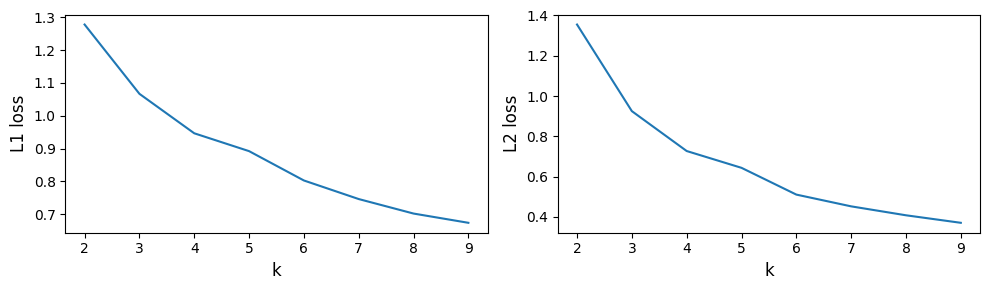

In [19]:
fig, axes = plt.subplots(1,2,figsize=(10,3))
axes[0].plot(range(2,10), vae_loss_l1_list)
axes[0].set_xlabel("k", fontsize=12)
axes[0].set_ylabel("L1 loss", fontsize=12)
axes[1].plot(range(2,10), vae_loss_l2_list)
axes[1].set_xlabel("k", fontsize=12)
axes[1].set_ylabel("L2 loss", fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(res_path, 'vae_dfnc_kmeans_loss.png'), dpi=500)

In [20]:
n_state = 5

np.save(os.path.join(res_path, 'vae_loss_l1_list.npy'), vae_loss_l1_list)
np.save(os.path.join(res_path, 'vae_loss_l2_list.npy'), vae_loss_l2_list)
np.save(os.path.join(res_path, f'vae_label_state{n_state}.npy'), vae_label_list[n_state-2])
np.save(os.path.join(res_path, f'vae_cluster_center_state{n_state}.npy'), vae_cluster_center_list[n_state-2])
np.save(os.path.join(res_path, f'vae_all_state_state{n_state}.npy'), vae_all_state_list[n_state-2])

# vae_loss_l1_list = np.load(os.path.join(res_path, 'vae_loss_l1_list.npy'))
# vae_loss_l2_list = np.load(os.path.join(res_path, 'vae_loss_l2_list.npy'))
# vae_kmeans_state = np.load(os.path.join(res_path, f'vae_all_state_state{n_state}.npy'))
# vae_kmeans_label = np.load(os.path.join(res_path, f'vae_label_state{n_state}.npy'))
# vae_kmeans_cluster_center = np.load(os.path.join(res_path, f'vae_cluster_center_state{n_state}.npy'))

In [21]:
vae_kmeans_state = vae_all_state_list[n_state-2]
vae_kmeans_label = vae_label_list[n_state-2]
vae_kmeans_cluster_center = vae_cluster_center_list[n_state-2]

vae_num_sub_per_state, vae_ratio_sub_per_state = compute_sub_per_state(vae_kmeans_label, n_pt_train)
vae_num_fnc_per_state, vae_ratio_fnc_per_state = compute_fnc_per_state(vae_kmeans_label, n_pt_train)

vae_label_pt = vae_kmeans_label[:n_pt_train*n_window]
vae_label_hc = vae_kmeans_label[n_pt_train*n_window:]
vae_dfnc_data_train_pt = vae_dfnc_data_train[:n_pt_train*n_window,:]
vae_dfnc_data_train_hc = vae_dfnc_data_train[n_pt_train*n_window:,:]

vae_dfnc_state = np.zeros((3, n_state, 53, 53))
for i in range(n_state):
  cluster_median_1d_pt = np.median(vae_dfnc_data_train_pt[np.where(vae_label_pt == i)[0], :], axis=0)
  cluster_median_1d_hc = np.median(vae_dfnc_data_train_hc[np.where(vae_label_hc == i)[0], :], axis=0)
  vae_dfnc_state[0,i] = vector2matrix(cluster_median_1d_pt)
  vae_dfnc_state[1,i] = vector2matrix(cluster_median_1d_hc)
  vae_dfnc_state[2,i] = vae_dfnc_state[0,i] - vae_dfnc_state[1,i]

# sort dFNC states by similarity between original and generated dFNC states
corr = np.zeros((2, n_state, n_state))
for i in range(n_state):
  for j in range(n_state):
    for k in range(2):
      corr[k,i,j] = np.corrcoef((dfnc_state[k,i,:].flatten(), vae_dfnc_state[k,j,:].flatten()))[0,1]
vae_sorted_state_ind = np.argmax(corr[0], axis=1)

vae_unique_sorted_state_ind = find_unique_ind(vae_sorted_state_ind, corr, vae_ratio_fnc_per_state)
vae_ratio_fnc_per_state_sorted = vae_ratio_fnc_per_state[:, vae_unique_sorted_state_ind]

print(vae_num_sub_per_state)
print(vae_ratio_sub_per_state)
print(vae_num_fnc_per_state)
print(vae_ratio_fnc_per_state)
print(vae_unique_sorted_state_ind)

[[82. 51. 92. 49. 40.]
 [78. 97. 92. 90. 65.]]
[[0.5125     0.34459459 0.5        0.35251799 0.38095238]
 [0.4875     0.65540541 0.5        0.64748201 0.61904762]]
[[3270. 1876. 6202. 1850. 1187.]
 [2902. 4776. 2791. 3571. 2400.]]
[[0.52981205 0.28202044 0.6896475  0.34126545 0.3309172 ]
 [0.47018795 0.71797956 0.3103525  0.65873455 0.6690828 ]]
[4 2 0 1 3]


0.9372383480739378 0.8875262228777445
0.9810353512177142 0.9803632414511455
0.9020063569692355 0.9000643822629723
0.976290173871273 0.984503030771174
0.9577273566329925 0.9613743461038936


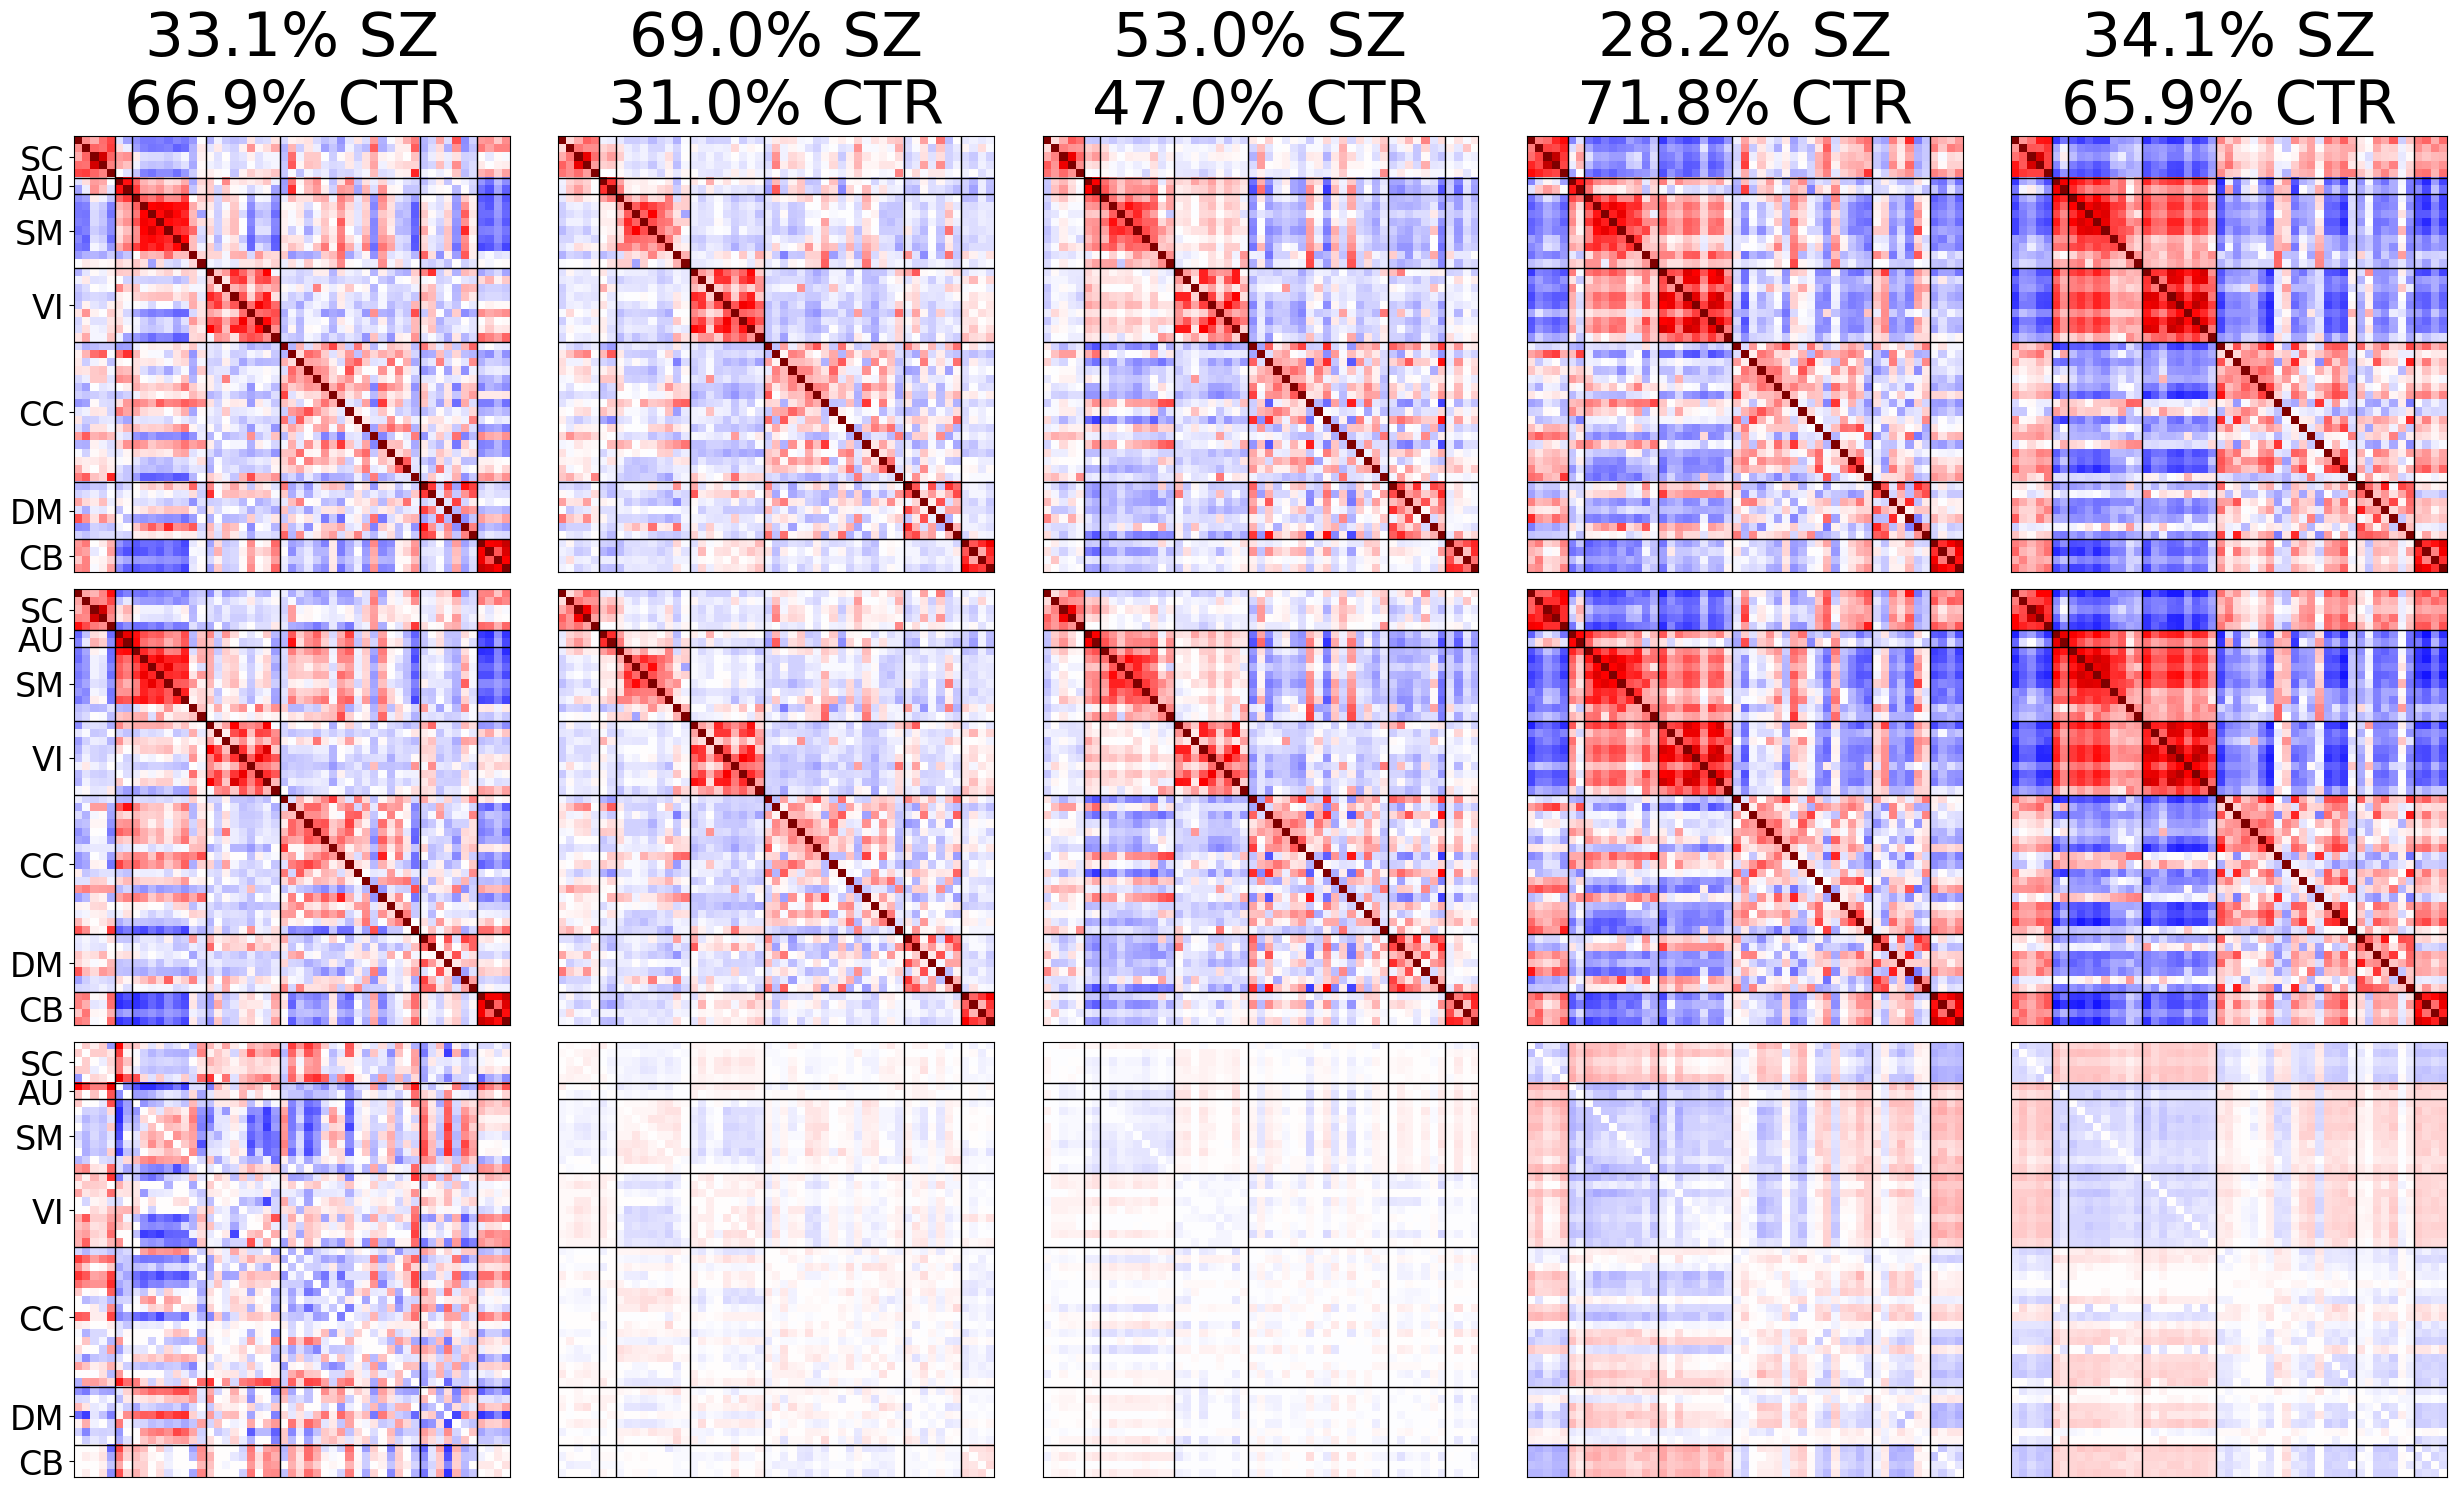

In [22]:
corr_state = np.zeros((2, n_state))
vae_dfnc_state_sorted = np.zeros((3, n_state, 53, 53))

fig, axes = plt.subplots(nrows=3, ncols=n_state, figsize=(5*n_state, 5*3))

for i, j in enumerate(np.arange(n_state)[vae_unique_sorted_state_ind]):
  state_pt = vae_dfnc_data_train_pt[np.where(vae_label_pt == j)[0], :]
  state_hc = vae_dfnc_data_train_hc[np.where(vae_label_hc == j)[0], :]
  stat, pvalue = stats.ttest_ind(a=state_pt, b=state_hc, equal_var=True)
  pvalue_map = vector2matrix(pvalue)
  pvalue_mask = pvalue_map <= (0.05/len(pvalue))
  upper_triangle_mask = np.triu(np.ones_like(pvalue_mask)).astype(bool)
  pvalue_mask[upper_triangle_mask] = 1
  cluster_median_1d_pt = np.median(state_pt, axis=0)
  cluster_median_1d_hc = np.median(state_hc, axis=0)
  vae_dfnc_state_sorted[0,i] = vector2matrix(cluster_median_1d_pt)
  vae_dfnc_state_sorted[1,i] = vector2matrix(cluster_median_1d_hc)
  vae_dfnc_state_sorted[2,i] = vae_dfnc_state_sorted[0,i] - vae_dfnc_state_sorted[1,i]

  if i == 0:
    show_xticks = True
  else:
    show_xticks = False

  plot_fnc(vae_dfnc_state_sorted[0,i], axes[0,i], f"{round(vae_ratio_fnc_per_state_sorted[0,i]*100,1)}% SZ\n{round(vae_ratio_fnc_per_state_sorted[1,i]*100,1)}% CTR", show_xticks=show_xticks)
  plot_fnc(vae_dfnc_state_sorted[1,i], axes[1,i], show_xticks=show_xticks)
  plot_fnc(vae_dfnc_state_sorted[2,i] * pvalue_mask * 2, axes[2,i], show_xticks=show_xticks)

  corr_state[0,i] = np.corrcoef((dfnc_state[0,i,:].flatten(), vae_dfnc_state_sorted[0,i,:].flatten()))[0,1]
  corr_state[1,i] = np.corrcoef((dfnc_state[1,i,:].flatten(), vae_dfnc_state_sorted[1,i,:].flatten()))[0,1]
  print(corr_state[0,i], corr_state[1,i])

plt.tight_layout()
plt.savefig(os.path.join(res_path, f'vae_dfnc_kmeans_{n_state}states_pt_hc_pt-hc_sorted.png'), dpi=500)

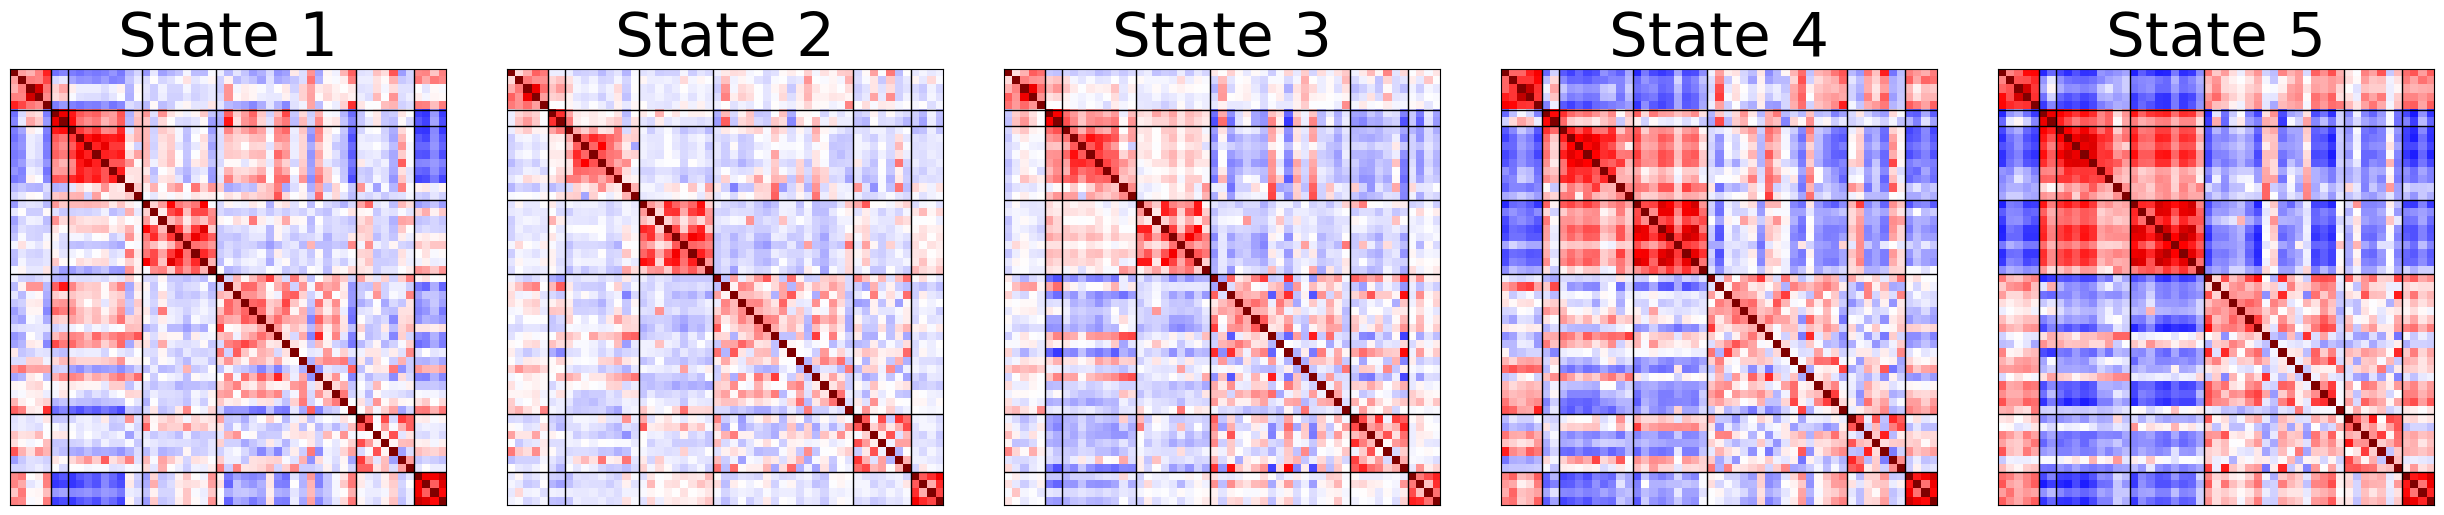

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=n_state, figsize=(5*n_state, 5))

for i, j in enumerate(np.arange(n_state)[vae_unique_sorted_state_ind]):
  state = vae_dfnc_data_train[np.where(vae_kmeans_label==j)[0],:]
  state_median_1d = np.median(state, axis=0)
  state_median_2d = vector2matrix(state_median_1d)
  plot_fnc(state_median_2d, axes[i], f"State {i+1}")

plt.tight_layout()
plt.savefig(os.path.join(res_path, f'vae_dfnc_kmeans_{n_state}states_pt_sorted.png'), bbox_inches='tight', dpi=500)

In [24]:
vae_dwell_time = vae_num_fnc_per_state / vae_num_sub_per_state
vae_dwell_time_sorted = vae_dwell_time[:, vae_unique_sorted_state_ind]

vae_kmeans_label_2d = vae_kmeans_label.reshape((n_train, n_window))
vae_dwell_state_mean_pt, vae_dwell_state_ste_pt, vae_dwell_state_mean_hc, vae_dwell_state_ste_hc, vae_dwell_state_pvalue = compute_dwell_state(vae_kmeans_label_2d, vae_unique_sorted_state_ind, n_pt_train, n_hc_train)
vae_transition_matrix_pt, vae_transition_matrix_hc, vae_transition_matrix, vae_transition_matrix_pvalue = compute_transition_matrix(vae_kmeans_label_2d, vae_unique_sorted_state_ind, n_pt_train)

np.save(os.path.join(res_path, 'vae_dwell_time.npy'), vae_dwell_time_sorted)
np.save(os.path.join(res_path, 'vae_dwell_state_pvalue.npy'), vae_dwell_state_pvalue)
np.save(os.path.join(res_path, 'vae_dwell_state_mean_pt.npy'), vae_dwell_state_mean_pt)
np.save(os.path.join(res_path, 'vae_dwell_state_ste_pt.npy'), vae_dwell_state_ste_pt)
np.save(os.path.join(res_path, 'vae_dwell_state_mean_hc.npy'), vae_dwell_state_mean_hc)
np.save(os.path.join(res_path, 'vae_dwell_state_ste_hc.npy'), vae_dwell_state_ste_hc)
np.save(os.path.join(res_path, 'vae_transition_matrix_pt.npy'), vae_transition_matrix_pt)
np.save(os.path.join(res_path, 'vae_transition_matrix_hc.npy'), vae_transition_matrix_hc)
np.save(os.path.join(res_path, 'vae_sorted_state_ind.npy'), vae_unique_sorted_state_ind)
np.save(os.path.join(res_path, 'vae_kmeans_cluster_center.npy'), vae_kmeans_cluster_center)
np.save(os.path.join(res_path, 'vae_kmeans_label.npy'), vae_kmeans_label)
np.save(os.path.join(res_path, 'vae_transition_matrix.npy'), vae_transition_matrix)
np.save(os.path.join(res_path, 'vae_transition_matrix_pvalue.npy'), vae_transition_matrix_pvalue)

In [25]:
vae_dfnc_data_test = np.zeros(dfnc_data_test_2d.shape)
for i in range(dfnc_data_test_2d.shape[0]):
  vae_z = torch.Tensor([[z_test[i,0], z_test[i,1]]])
  vae_dfnc_data_test[i,:] = np.squeeze(model.decode(vae_z).detach().numpy())
np.save(os.path.join(res_path, 'vae_dfnc_data_test.npy'), vae_dfnc_data_test)

# vae_dfnc_data_test = np.load(os.path.join(res_path, 'vae_dfnc_data_test.npy'))
# vae_kmeans_label_test = np.load(os.path.join(res_path, 'vae_kmeans_label_test.npy'))

In [26]:
kmeans = vae_kmeans_list[n_state-2]
vae_kmeans_label_test = kmeans.predict(z_test)

vae_num_sub_per_state_test, vae_ratio_sub_per_state_test = compute_sub_per_state(vae_kmeans_label_test, n_pt_test)
vae_num_fnc_per_state_test, vae_ratio_fnc_per_state_test = compute_fnc_per_state(vae_kmeans_label_test, n_pt_test)

vae_label_pt_test = vae_kmeans_label_test[:n_pt_test*n_window]
vae_label_hc_test = vae_kmeans_label_test[n_pt_test*n_window:]
vae_dfnc_data_test_pt = vae_dfnc_data_test[:n_pt_test*n_window,:]
vae_dfnc_data_test_hc = vae_dfnc_data_test[n_pt_test*n_window:,:]

vae_dfnc_state_test = np.zeros((3, n_state, 53, 53))
for i in range(n_state):
  cluster_median_1d_pt = np.median(vae_dfnc_data_test_pt[np.where(vae_label_pt_test == i)[0], :], axis=0)
  cluster_median_1d_hc = np.median(vae_dfnc_data_test_hc[np.where(vae_label_hc_test == i)[0], :], axis=0)
  vae_dfnc_state_test[0,i] = vector2matrix(cluster_median_1d_pt)
  vae_dfnc_state_test[1,i] = vector2matrix(cluster_median_1d_hc)
  vae_dfnc_state_test[2,i] = vae_dfnc_state_test[0,i] - vae_dfnc_state_test[1,i]

corr_test = np.zeros((2, n_state, n_state))
for i in range(n_state):
  for j in range(n_state):
    for k in range(2):
      corr_test[k,i,j] = np.corrcoef((dfnc_state_test[k,i,:].flatten(), vae_dfnc_state_test[k,j,:].flatten()))[0,1]

vae_sorted_state_ind_test = np.argmax(corr_test[0], axis=1)
vae_unique_sorted_state_ind_test = find_unique_ind(vae_sorted_state_ind_test, corr_test, vae_ratio_fnc_per_state_test)
vae_ratio_fnc_per_state_sorted_test = vae_ratio_fnc_per_state_test[:, vae_unique_sorted_state_ind_test]
print(vae_unique_sorted_state_ind_test)

[4 2 0 1 3]


0.8778457225699846 0.7588311961680156
0.9621754688221177 0.9528208521702956
0.9017179037594967 0.8925849141064499
0.9282199790469051 0.9658399264460547
0.8704810359563694 0.9511055047675842


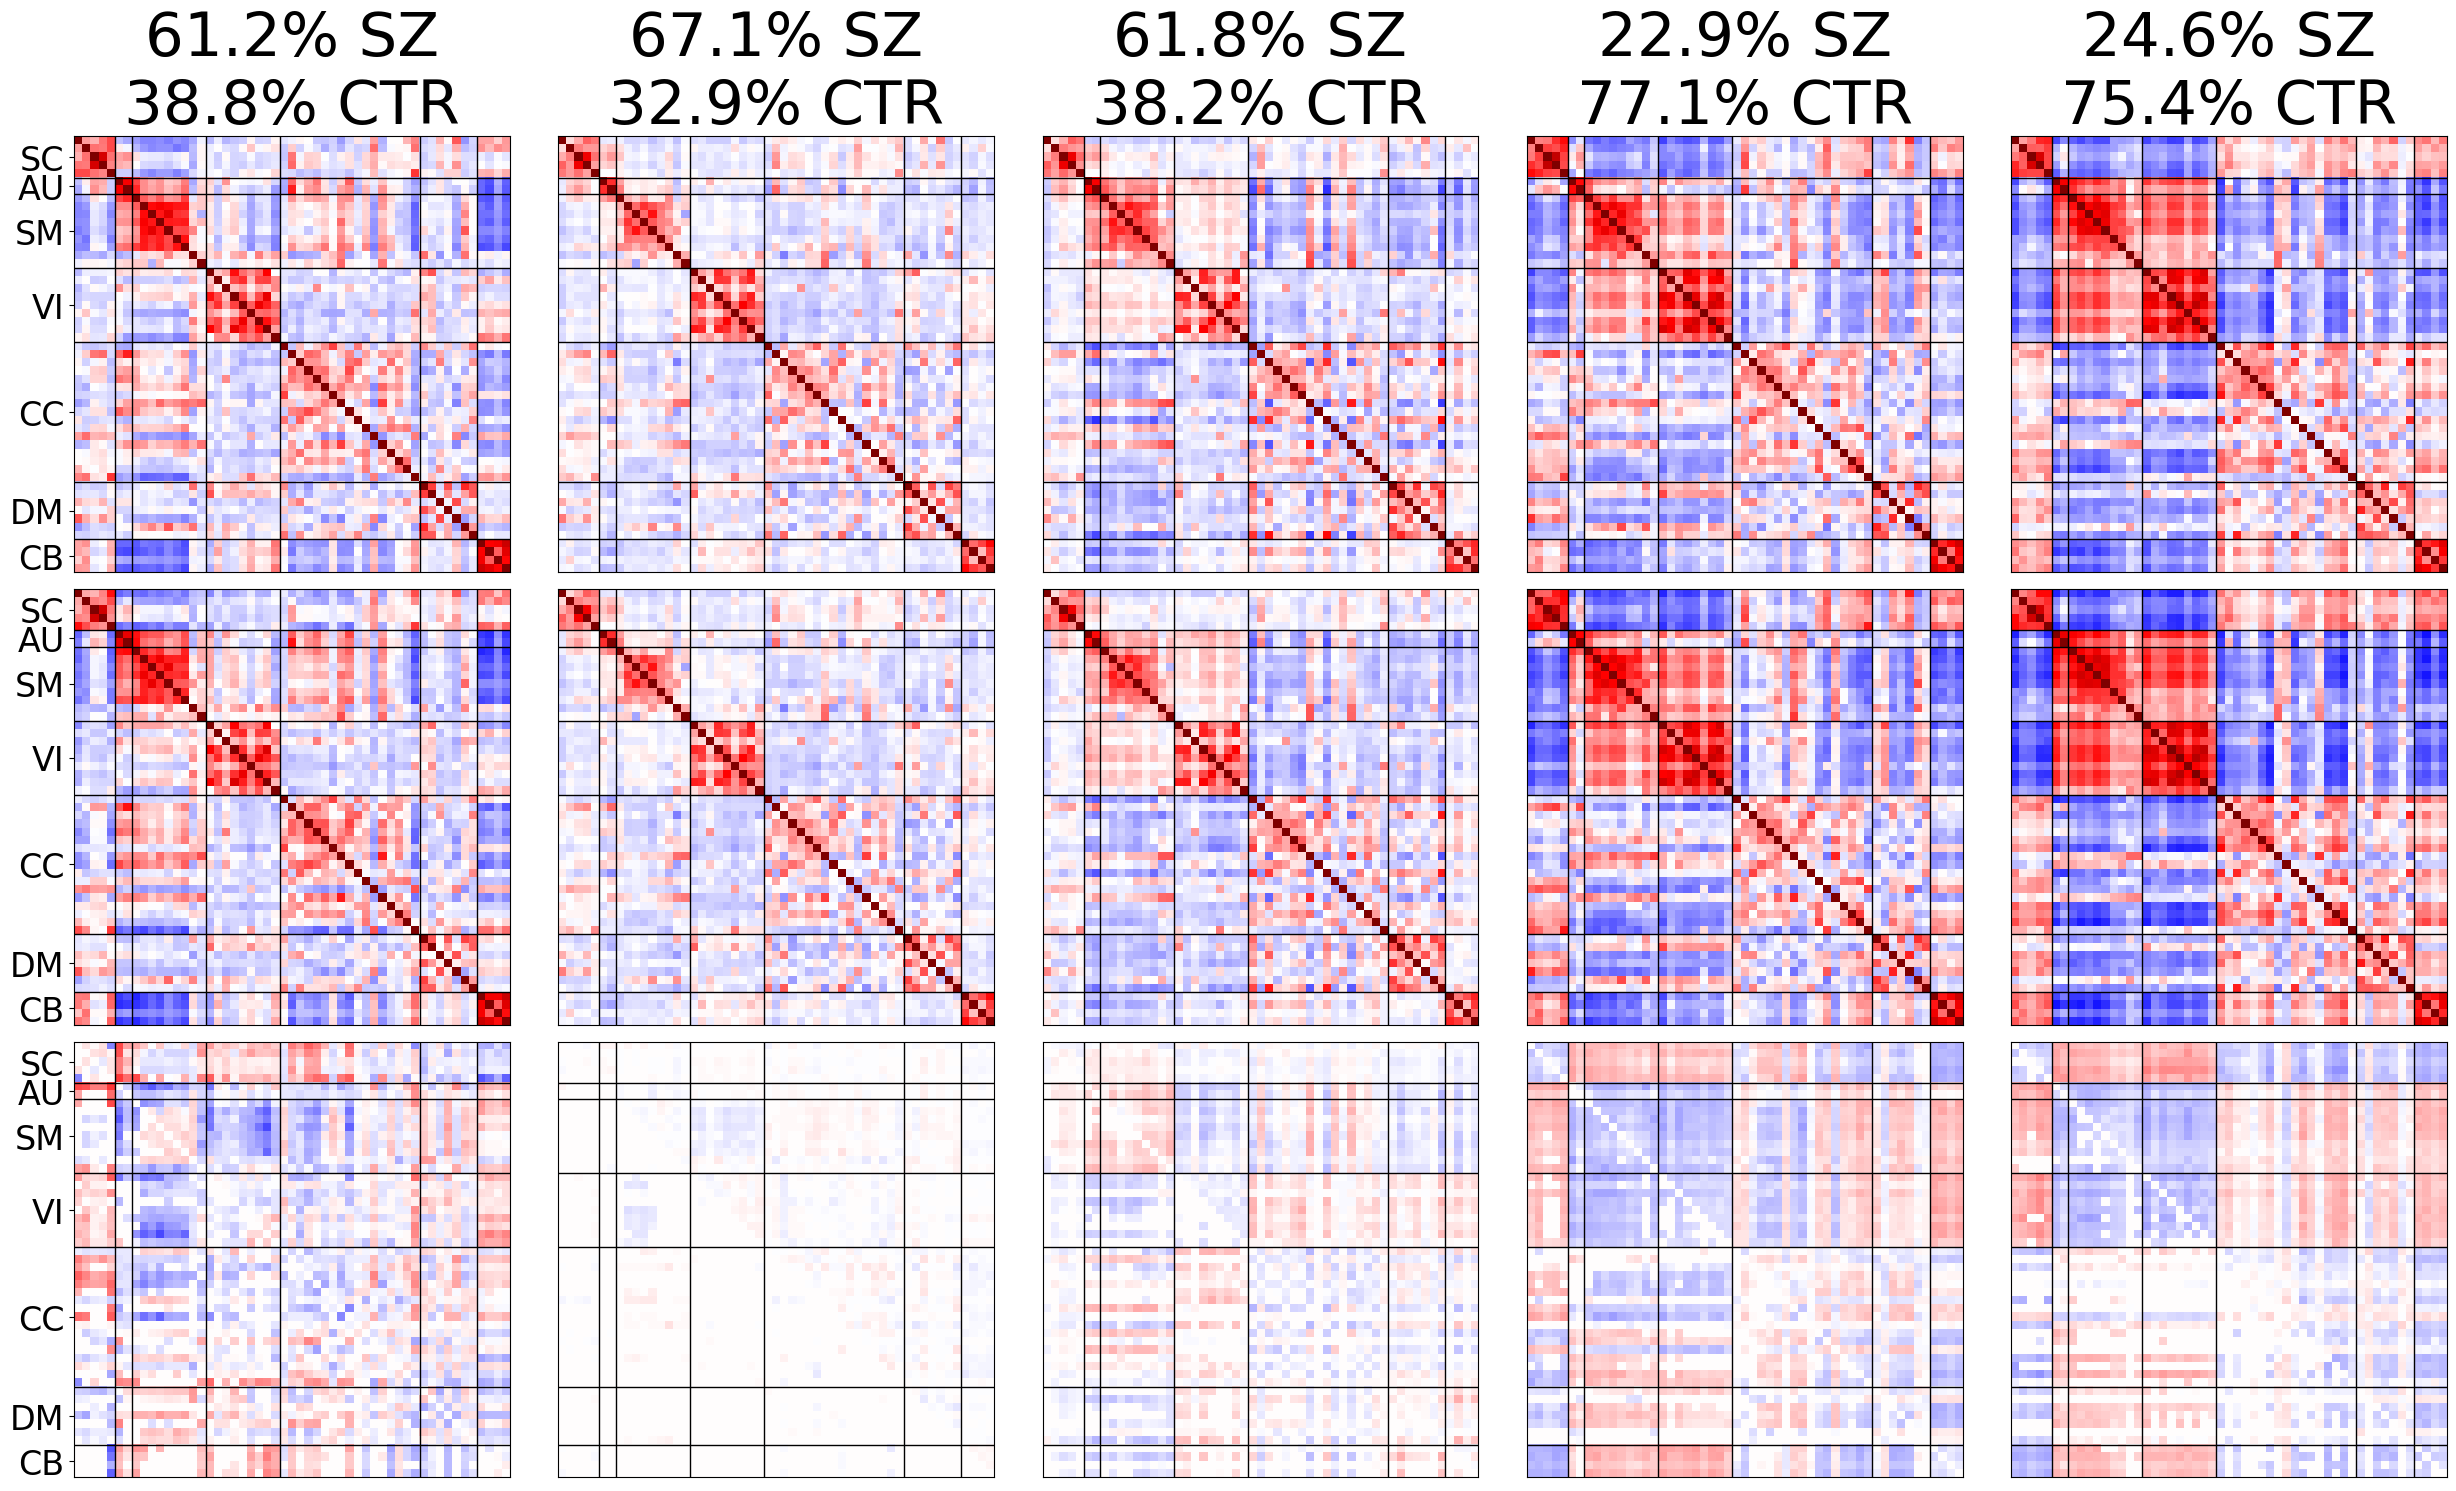

In [27]:
vae_corr_state_test = np.zeros((2, 5))
vae_dfnc_state_test = np.zeros((3, 5, 53, 53))

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(5*n_state, 5*3))

for i, j in enumerate(np.arange(n_state)[vae_unique_sorted_state_ind_test]):
  state_pt = vae_dfnc_data_test_pt[np.where(vae_label_pt_test == j)[0], :]
  state_hc = vae_dfnc_data_test_hc[np.where(vae_label_hc_test == j)[0], :]

  stat, pvalue = stats.ttest_ind(a=state_pt, b=state_hc, equal_var=True)
  pvalue_map = vector2matrix(pvalue)
  pvalue_mask = pvalue_map <= (0.05/len(pvalue))
  upper_triangle_mask = np.triu(np.ones_like(pvalue_mask)).astype(bool)
  pvalue_mask[upper_triangle_mask] = 1

  cluster_median_1d_pt = np.median(state_pt, axis=0)
  cluster_median_1d_hc = np.median(state_hc, axis=0)

  vae_dfnc_state_test[0,i] = vector2matrix(cluster_median_1d_pt)
  vae_dfnc_state_test[1,i] = vector2matrix(cluster_median_1d_hc)
  vae_dfnc_state_test[2,i] = vae_dfnc_state_test[0,i] - vae_dfnc_state_test[1,i]

  if i == 0:
    show_xticks = True
  else:
    show_xticks = False

  plot_fnc(vae_dfnc_state_test[0,i], axes[0,i], f"{round(vae_ratio_fnc_per_state_sorted_test[0,i]*100,1)}% SZ\n{round(vae_ratio_fnc_per_state_sorted_test[1,i]*100,1)}% CTR", show_xticks=show_xticks)
  plot_fnc(vae_dfnc_state_test[1,i], axes[1,i], show_xticks=show_xticks)
  plot_fnc(vae_dfnc_state_test[2,i] * pvalue_mask * 2, axes[2,i], show_xticks=show_xticks)

  vae_corr_state_test[0,i] = np.corrcoef((dfnc_state_test[0,i,:].flatten(), vae_dfnc_state_test[0,i,:].flatten()))[0,1]
  vae_corr_state_test[1,i] = np.corrcoef((dfnc_state_test[1,i,:].flatten(), vae_dfnc_state_test[1,i,:].flatten()))[0,1]
  print(vae_corr_state_test[0,i], vae_corr_state_test[1,i])

plt.tight_layout()
plt.savefig(os.path.join(res_path, f'vae_dfnc_kmeans_{n_state}states_pt_hc_pt-hc_sorted_test.png'), dpi=500)

In [28]:
vae_corr_train_test = np.zeros((5,5))
for i in range(5):
    for j in range(5):
        vae_corr_train_test[i,j] = np.corrcoef((vae_dfnc_state[2][i,:,:][np.triu_indices(53, 1)], vae_dfnc_state_test[2][j,:,:][np.triu_indices(53, 1)]))[0,1]
        if vae_corr_train_test[i,j] > 0.5:
            print(f"train state {i+1}, test state {j+1}, {vae_corr_train_test[i,j]:.3f}")

train state 2, test state 1, 0.561
train state 2, test state 4, 0.962
train state 2, test state 5, 0.712
train state 3, test state 2, 0.607
train state 4, test state 4, 0.852
train state 4, test state 5, 0.926
train state 5, test state 1, 0.906


In [29]:
vae_dwell_time_test = vae_num_fnc_per_state_test / vae_num_sub_per_state_test
vae_dwell_time_sorted_test = vae_dwell_time_test[:, vae_unique_sorted_state_ind_test]

vae_kmeans_label_2d_test = vae_kmeans_label_test.reshape((n_test, n_window))
vae_dwell_state_mean_pt_test, vae_dwell_state_ste_pt_test, vae_dwell_state_mean_hc_test, vae_dwell_state_ste_hc_test, vae_dwell_state_pvalue_test = compute_dwell_state(vae_kmeans_label_2d_test, vae_unique_sorted_state_ind_test, n_pt_test, n_hc_test)
vae_transition_matrix_pt_test, vae_transition_matrix_hc_test, vae_transition_matrix_test, vae_transition_matrix_pvalue_test = compute_transition_matrix(vae_kmeans_label_2d_test, vae_unique_sorted_state_ind_test, n_pt_test)

np.save(os.path.join(res_path, 'vae_dwell_time_test.npy'), vae_dwell_time_sorted_test)
np.save(os.path.join(res_path, 'vae_dwell_state_pvalue_test.npy'), vae_dwell_state_pvalue_test)
np.save(os.path.join(res_path, 'vae_dwell_state_mean_pt_test.npy'), vae_dwell_state_mean_pt_test)
np.save(os.path.join(res_path, 'vae_dwell_state_ste_pt_test.npy'), vae_dwell_state_ste_pt_test)
np.save(os.path.join(res_path, 'vae_dwell_state_mean_hc_test.npy'), vae_dwell_state_mean_hc_test)
np.save(os.path.join(res_path, 'vae_dwell_state_ste_hc_test.npy'), vae_dwell_state_ste_hc_test)
np.save(os.path.join(res_path, 'vae_transition_matrix_pt_test.npy'), vae_transition_matrix_pt_test)
np.save(os.path.join(res_path, 'vae_transition_matrix_hc_test.npy'), vae_transition_matrix_hc_test)
np.save(os.path.join(res_path, 'vae_sorted_state_ind_test.npy'), vae_unique_sorted_state_ind_test)
np.save(os.path.join(res_path, 'vae_kmeans_label_test.npy'), vae_kmeans_label_test)
np.save(os.path.join(res_path, 'vae_transition_matrix_test.npy'), vae_transition_matrix_test)
np.save(os.path.join(res_path, 'vae_transition_matrix_pvalue_test.npy'), vae_transition_matrix_pvalue_test)

In [30]:
dfnc_corr_matrix_train = np.corrcoef(vae_dfnc_data_train, dfnc_data_train_2d)
dfnc_corr_vector_train = np.diag(dfnc_corr_matrix_train[n_train*n_window:,:n_train*n_window])

dfnc_corr_matrix_test = np.corrcoef(vae_dfnc_data_test, dfnc_data_test_2d)
dfnc_corr_vector_test = np.diag(dfnc_corr_matrix_test[n_test*n_window:,:n_test*n_window])

print(np.mean(dfnc_corr_vector_train))
print(np.mean(dfnc_corr_vector_test))

np.save(os.path.join(res_path, 'dfnc_corr_train.npy'), dfnc_corr_vector_train)
np.save(os.path.join(res_path, 'dfnc_corr_test.npy'), dfnc_corr_vector_test)

0.6104197806152382
0.5740802044209428
